In [1]:
dataset_name = "W13_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML

import Jupyter_module_loader
from utility import *
import gaussian_kde


In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (5173, 12)


In [5]:
from cycler import cycler
def nice_bar_plot(ser1, ser2, normalize = 'columns', sort_labels=False, output_folder = BES_output_folder,
                  text_width=8, text_fontsize=14, min_sample_size=100, title=None, drop_insig=True, fuckErrors=True,
                  mask=1, title_fontsize=14, color=None, label=None, char_limit=40):
    var1 = ser1.name
    var2 = ser2.name
    
    mask = ser1.notnull() & ser2.notnull() & mask
    ids = ser1[mask].index
    ser1 = ser1[mask]
    ser2 = ser2[mask]
#     ct = pd.crosstab( ser1, ser2,
#                       values= get_all_weights(mask), aggfunc=sum, normalize=normalize)*100
    ct = pd.crosstab( ser1, ser2,
                      values= get_all_weights(ids), aggfunc=sum, normalize=normalize)*100    
    if sort_labels:
        sorted_labels = list(ser2.value_counts().index)
    else:
        sorted_labels = list(ser2.cat.categories)
           

    unweighted = pd.crosstab( ser1, ser2 )
    errors = 100 * np.sqrt(unweighted)/unweighted     

    labels_by_sample_size = {unweighted.sum().values[x]:sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))}    
    labels_by_sample_size = {sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")":unweighted.sum().values[x] for x in range(0,len(sorted_labels))}    
    labels_restricted = [x for x in labels_by_sample_size.keys() if labels_by_sample_size[x] > min_sample_size] 
#     return labels_by_sample_size, labels_restricted
    if drop_insig:
        rubbish_entries = ct<errors
        ct[rubbish_entries]=np.nan
        errors[rubbish_entries]=np.nan
#     return(sorted_labels, errors, labels_by_sample_size)
    all_nan_rows = ~errors.isnull().any(axis=1)
    errors.columns = list( labels_by_sample_size.keys() )
   
    ct.columns = list( labels_by_sample_size.keys() )
    ct = ct.loc[all_nan_rows, labels_restricted]
#     return errors, labels_restricted
    errors = errors.loc[all_nan_rows, labels_restricted]
#     errors=errors.T
#     return errors
#     return errors, ct
    treatment = var2 +" by " + var1
    output_subfolder = create_subdir(output_folder, treatment)
    import textwrap 

    wrapper = textwrap.TextWrapper(width=text_width) 

    stacked = ct.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    err_stacked = errors.stack().reset_index().rename(columns={0:'%',"level_1":var2})
    fig = plt.figure(figsize=(20, 8))
    ax = fig.subplots()

#     a = [np.ones(16),np.ones(16)]
#     a = errors.values
#     return a
#     iter(a)    
    
    stacked[var1] = stacked[var1].apply( lambda x: x +" (N="+str(unweighted.sum(axis=1).loc[x])+")" )
    stacked[var1].cat.set_categories(stacked[var1].cat.categories[all_nan_rows],inplace=True)
#     return stacked
#     return stacked['%'].shape,err_stacked["%"].values.reshape(len(stacked),1).shape
    if fuckErrors:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted);
    else:
        bar = sns.barplot(x = stacked[var2],
                    y = stacked['%'],
                    hue = stacked[var1],
                    ax = ax, order = labels_restricted,
                    yerr = errors.values);        
                    # err_stacked["%"].values );
# .reshape(len(stacked),1)

#     hatch_cycle = cycler(hatch=['/', '*', '-','+','x','\\','o' '|'])
    # Define some hatches
#     hatches = ['-', '+', 'x', '\\', '*', 'o']
    hatch_cycle = cycle(['/', '*', '-','+','x','\\','o', '|'])
    # Loop over the bars
    for i,thisbar in enumerate(bar.patches):
        # Set a different hatch for each bar
        thisbar.set_hatch(next(hatch_cycle))

    if title is None:
        title = var2 +" by " + var1
    plt.title(title, fontsize=title_fontsize)
    sorted_labels = [sorted_labels[x]+" (N="+str(unweighted.sum().values[x])+")" for x in range(0,len(sorted_labels))]
    ax.set_xticklabels([ wrapper.fill(text=x) for x in labels_restricted], rotation=0, fontsize=text_fontsize);

    ax.annotate(dataset_citation, (0,0), (0, -140),
                     xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
    fname = output_subfolder + clean_filename(title, char_limit = char_limit) + ".png"
    fig.savefig( fname, bbox_inches='tight' )    

In [6]:
def get_all_weights(ids, specific_wave = None):

    if specific_wave is None:
        wts = BES_Panel.loc[ids, list(num_to_weight.values())]
    else:
        wts = BES_Panel.loc[ids, specific_wave]
    # wts.hist(bins=100,figsize=(16,12));

    wts = wts/wts.mean()
    # wts.mean(axis=1).hist(bins=100,figsize=(16,12));
    # # wts = wts/wts.mean(axis=1)
    wts = wts.mean(axis=1)
    wts =wts/wts.mean()
    return wts
# wts

In [7]:
def sort_by_wave(lst):
    dict_by_wave = {int(x.split("W")[-1]):x for x in lst}
    return [dict_by_wave[x] for x in sorted(dict_by_wave.keys())]
    
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

In [8]:
pan_dataset_ages = pd.read_msgpack(    BES_small_data_files + "pan_dataset_ages"+".msgpack" )
pan_dataset_allr_values = pd.read_csv( BES_small_data_files + "pan_dataset_allr_values"+".csv" )

In [11]:
search(BES_Panel,"gor")

gorW11             31014
gorW12             34464
EUMIICategoryW7    22599
EUMIICategoryW8    16181
gorW13             31046
gorW2              30461
gorW3              27837
gorW6              28581
gor                66801
dtype: int64

In [18]:
search(BES_Panel,"monarch",mask = BES_Panel["gorW12"].notnull())

monarchW8    22362
dtype: int64

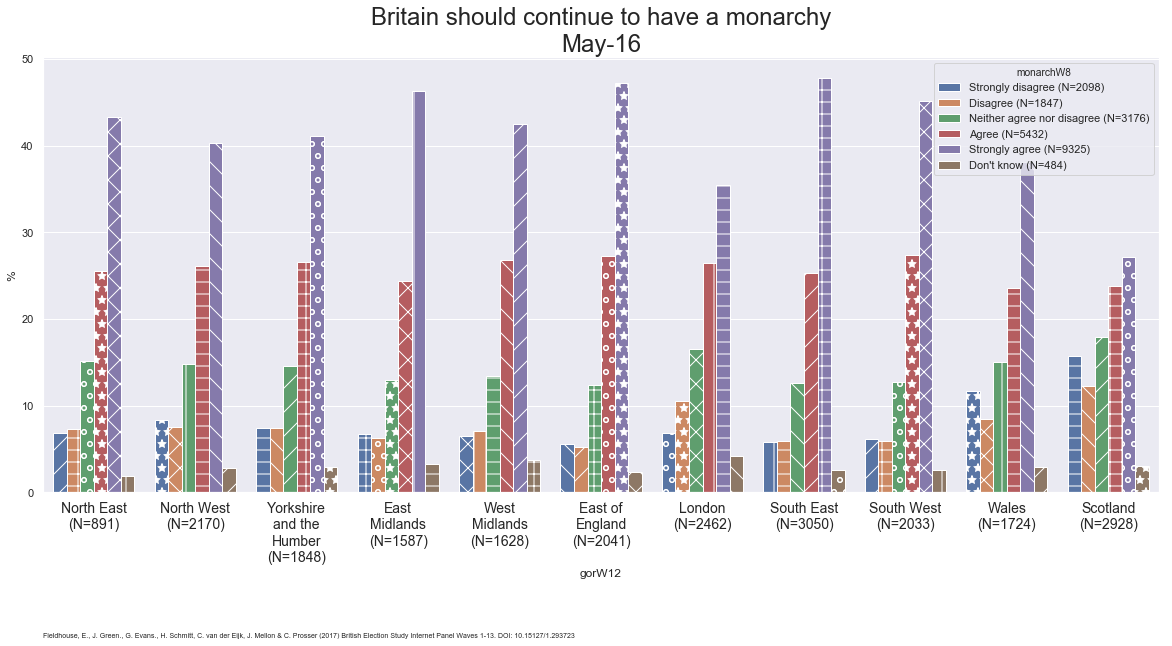

In [20]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 8

var1 ="monarchW8"
var2 ="gorW12"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='columns',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Britain should continue to have a monarchy"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [21]:
search(BES_reduced_with_na,"monarch")

monarchW8__Strongly agree    32653
dtype: int64

In [22]:
# df["amalgamted_enviroprotection"] = amalgamate_waves(BES_reduced_with_na,"enviroProtection")

pattern = "monarchW8__Strongly agree"
name = "monarchW8__Strongly agree"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,r,p,N
happyScotIndepResultNoW2__Extremely happy,0.51,0.00,2975
likeConW11__Strongly like,0.48,0.00,19519
likeMayW12__Strongly like,0.48,0.00,21150
generalElectionVoteUnsqueezeW12_Conservative,0.47,0.00,13837
leftRightW6__Right,0.47,0.00,16600
ptvConW12__Very likely,0.47,0.00,5155
devoResponsibleScotDefenceW11_The UK Parliament,0.46,0.00,2431
partyMemberNowW12_Conservative,0.45,0.00,2481
handleMIIConW12__Very well,0.45,0.00,4647
keepNukesW7__Strongly agree,0.45,0.00,21973


In [32]:
BES_reduced_with_na[search(BES_reduced_with_na,"(lr|al)\dW7W8W9").index].corrwith(BES_reduced_with_na["monarchW8__Strongly agree"])

lr1W7W8W9__Strongly agree   -0.314713
lr2W7W8W9__Strongly agree   -0.230135
lr3W7W8W9__Strongly agree   -0.264558
lr4W7W8W9__Strongly agree   -0.248289
lr5W7W8W9__Strongly agree   -0.176650
al1W7W8W9__Strongly agree    0.350522
al2W7W8W9__Strongly agree    0.271543
al3W7W8W9__Strongly agree    0.345445
al4W7W8W9__Strongly agree    0.286633
al5W7W8W9__Strongly agree    0.285783
dtype: float64

In [28]:
pan_dataset_allr_values.corrwith(BES_reduced_with_na["monarchW8__Strongly agree"])

Economic: Left(0) <-> Right(200){uniform}               0.174478
Social: Liberalism(0) <-> Conservatism(200){uniform}    0.195085
Economic: Left <-> Right{gaussian-ish}                  0.186178
Social: Liberalism <-> Conservatism{gaussian-ish}       0.201972
id                                                      0.004744
dtype: float64

In [25]:
# df["amalgamted_enviroprotection"] = amalgamate_waves(BES_reduced_with_na,"enviroProtection")

pattern = "monarchW8__Strongly agree"
name = "monarchW8__Strongly agree"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na[BES_Panel["country"]=="Wales"], name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
leftRightW6__Right,0.52,0.00,1647
likeConW10__Strongly like,0.5,0.00,1360
likeMayW12__Strongly like,0.5,0.00,1636
approveUKGovtW11__Strongly approve,0.48,0.00,1507
likeBorisW7__Strongly like,0.48,0.00,1919
generalElectionVoteUnsqueezeW12_Conservative,0.48,0.00,1079
keepNukesW7__Strongly agree,0.48,0.00,1882
ptvConW11__Very likely,0.48,0.00,1469
thatcherGoodW1_Good for Britain,0.47,0.00,1410
conGovTrustW5__ Would do a good job,0.47,0.00,1799


In [26]:
# df["amalgamted_enviroprotection"] = amalgamate_waves(BES_reduced_with_na,"enviroProtection")

pattern = "monarchW8__Strongly agree"
name = "monarchW8__Strongly agree"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na[BES_Panel["country"]=="England"], name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
partyMemberNowW12_Conservative,0.45,0.00,1736
likeMayW11__Strongly like,0.45,0.00,15455
likeConW11__Strongly like,0.45,0.00,15460
generalElectionVoteUnsqueezeW12_Conservative,0.44,0.00,10754
leftRightW9__Right,0.44,0.00,4196
ptvConW12__Very likely,0.44,0.00,4032
approveUKGovtW11__Strongly approve,0.42,0.00,15715
thatcherGoodW1_Good for Britain,0.41,0.00,9817
handleMIIConW12__Very well,0.41,0.00,3641
likeBorisW13__Strongly like,0.41,0.00,7536


In [27]:
# df["amalgamted_enviroprotection"] = amalgamate_waves(BES_reduced_with_na,"enviroProtection")

pattern = "monarchW8__Strongly agree"
name = "monarchW8__Strongly agree"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na[BES_Panel["country"]=="Scotland"], name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
britishnessW12__Very strongly British,0.63,0.00,623
handleMIIConW12__Very well,0.58,0.00,642
keepNukesW12__Strongly agree,0.57,0.00,2774
likeConW12__Strongly like,0.57,0.00,2849
likeMayW12__Strongly like,0.56,0.00,2852
ptvConW12__Very likely,0.56,0.00,705
approveUKGovtW11__Strongly approve,0.55,0.00,2578
handleEUNegotiateW12__Very well,0.54,0.00,2755
integrityMayW10__Complete integrity,0.54,0.00,579
generalElectionVoteUnsqueezeW12_Conservative,0.53,0.00,2004


In [12]:
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [13]:

       
# transform a column of data until it's as approximately normally distributed as can be
# because most Machine Learning/Statistical methods assume data is ~normally distributed
# basically, what people normally do randomly logging/square-rooting data, only automatically

from scipy import stats
def box_cox_normalise(ser, offset = 3, bw='scott'):
    
    
    # box cox lr_scale
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    x = ser.values +ser.values.min()+offset
    prob = stats.probplot(x, dist=stats.norm, plot=ax1)
    ax1.set_xlabel('')
    ax1.set_title('Probplot against normal distribution')
    ax2 = fig.add_subplot(312)
    xt, _ = stats.boxcox(x)
    prob = stats.probplot(xt, dist=stats.norm, plot=ax2)
    ax2.set_title('Probplot after Box-Cox transformation')
    ax3 = fig.add_subplot(313)
    xt_std = (xt-xt.mean())/xt.std()
    sns.kdeplot(xt_std, ax=ax3, bw=bw, cut=0);
    sns.kdeplot(np.random.normal(size=len(xt_std)), ax=ax3, cut=0);
    plt.suptitle(ser.name)
    return xt_std
    

def corrank(X):
    import itertools
    df = pd.DataFrame([[(i,j),X.loc[i,j]] for i,j in list(itertools.combinations(X.corr(), 2))],columns=['pairs','corr'])    
    print(df.sort_values(by='corr',ascending=False).dropna())
    
    
# messy but time saver
    
   
import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder,
                 dependence_plots = False, threshold = .1, min_features = 30,
                 title=None):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    if title is None:
        fig.suptitle(target_var);
    else:
        fig.suptitle(title);
        
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            clean_filename(name)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + clean_filename(name) + ".png", bbox_inches='tight')
            count = count + 1
            
def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=pd.qcut( pd.Series( target ),
                                                                                                  q=10,
                                                                                                  duplicates = 'drop',
                                                                                                ).cat.codes )
          
            

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)            
    
global var_list, mask
def xgboost_run(title, subdir=None, min_features=30, dependence_plots=False , output_folder=".."+os.sep+"Output"+os.sep,Treatment="default"):
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(output_folder,Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves)[mask]

        if subdir is None:
            output_subfolder = create_subdir(treatment_subfolder,target_var)
        else:
            output_subfolder = create_subdir(treatment_subfolder,subdir)

        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        explainer = shap.TreeExplainer(alg)
        shap_values = explainer.shap_values(train)
        
#         shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = min_features, title=title,
                     dependence_plots=dependence_plots)
        
    return (explainer, shap_values)







############################ BASIC SETTINGS

from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    
optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1



def create_train(drop_other_waves):
    keep_list = df.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return df[keep_list]


def create_target(target_var):
    
    return df[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 508,
 max_depth=6,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.6,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=5e-05,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)





In [37]:
# Treatment = "xgboost_dealVnodeal"
# var_stub = "dealVnodeal"

# var_list = ["dealVnodeal_Leave without a deal"]
# var_stub_list = [var_stub,"euRefVote_Leave the EU","euID_The leave side","dealVremain_Remain in the EU",
#                  "delayOrNoDeal_Delay Brexit until parliament can agree a deal","euRefDoOver_Yes","cancelBrexit__Strongly agree",
#                  "euRefpastVote_Leave the EU","pastvote_EURef_Leave the EU",
#                  "willOfPeople__Strongly agree","dealVnodeal_Leave without a deal","profile_eurefvote_Leave the EU",
#                  "regretsIHaveAFewEU__I did not vote", 'noDealShortTerm__Extremely good', 'noDealLongTerm__Extremely good',
#                  "remainVnodeal_Remain in the EU"]

Treatment = "xgboost_monarchy"
var_stub = "monarch"
var_list = ["monarchW8__Strongly agree"]
var_stub_list = [var_stub]


# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
#    return 1
    return (BES_Panel["country"]=="England")
#     return (BES_Panel["profile_eurefvote"]=='Stay/remain in the EU')
#     return (BES_Panel["profile_past_vote_2017"]=="Labour")



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 1800,
 max_depth=10,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0.01,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



[0]	validation_0-rmse:2.6146
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:2.50703
[2]	validation_0-rmse:2.40493
[3]	validation_0-rmse:2.30906
[4]	validation_0-rmse:2.2188
[5]	validation_0-rmse:2.1344
[6]	validation_0-rmse:2.05456
[7]	validation_0-rmse:1.97855
[8]	validation_0-rmse:1.9079
[9]	validation_0-rmse:1.84162
[10]	validation_0-rmse:1.77924
[11]	validation_0-rmse:1.721
[12]	validation_0-rmse:1.66711
[13]	validation_0-rmse:1.61592
[14]	validation_0-rmse:1.56971
[15]	validation_0-rmse:1.52543
[16]	validation_0-rmse:1.48411
[17]	validation_0-rmse:1.44601
[18]	validation_0-rmse:1.41039
[19]	validation_0-rmse:1.37732
[20]	validation_0-rmse:1.34625
[21]	validation_0-rmse:1.31798
[22]	validation_0-rmse:1.2902
[23]	validation_0-rmse:1.26615
[24]	validation_0-rmse:1.244
[25]	validation_0-rmse:1.22328
[26]	validation_0-rmse:1.20454
[27]	validation_0-rmse:1.18629
[28]	validation_0-rmse:1.17001
[29]	validation_0-rmse:1.15481
[30]	validation_0-rms

[253]	validation_0-rmse:0.981511
[254]	validation_0-rmse:0.9816
[255]	validation_0-rmse:0.981583
[256]	validation_0-rmse:0.981602
[257]	validation_0-rmse:0.981625
[258]	validation_0-rmse:0.981712
[259]	validation_0-rmse:0.981757
[260]	validation_0-rmse:0.981774
[261]	validation_0-rmse:0.981795
[262]	validation_0-rmse:0.981811
[263]	validation_0-rmse:0.981843
[264]	validation_0-rmse:0.981884
[265]	validation_0-rmse:0.981744
[266]	validation_0-rmse:0.981802
[267]	validation_0-rmse:0.981815
[268]	validation_0-rmse:0.981863
[269]	validation_0-rmse:0.981862
[270]	validation_0-rmse:0.981965
[271]	validation_0-rmse:0.982054
[272]	validation_0-rmse:0.982019
[273]	validation_0-rmse:0.982095
[274]	validation_0-rmse:0.98208
[275]	validation_0-rmse:0.982074
[276]	validation_0-rmse:0.982054
[277]	validation_0-rmse:0.982005
[278]	validation_0-rmse:0.982022
[279]	validation_0-rmse:0.981979
[280]	validation_0-rmse:0.982027
[281]	validation_0-rmse:0.982013
[282]	validation_0-rmse:0.981976
[283]	validat

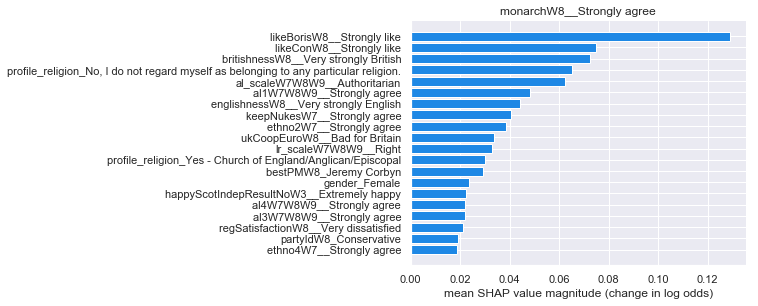

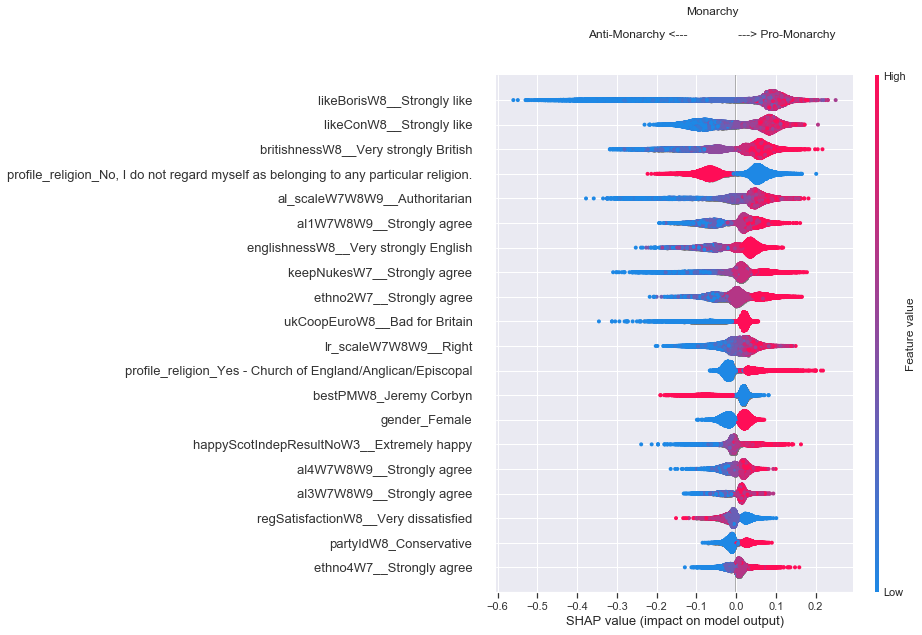

Wall time: 1h 9min 25s


In [38]:
%%time
colname = "Monarchy"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nAnti-Monarchy <---               ---> Pro-Monarchy")

In [18]:
search(BES_Panel,"gor")

gorW11             31014
gorW12             34464
EUMIICategoryW7    22599
EUMIICategoryW8    16181
gorW13             31046
gorW2              30461
gorW3              27837
gorW6              28581
gor                66801
dtype: int64

In [19]:
grammarW10W11 = amalgamate_waves(BES_Panel,"leftRight")

Amalgamating variables: 
{1: 'leftRightW1', 2: 'leftRightW2', 3: 'leftRightW3', 4: 'leftRightW4', 5: 'leftRightW5', 6: 'leftRightW6', 7: 'leftRightW7', 8: 'leftRightW8', 9: 'leftRightW9', 10: 'leftRightW10', 11: 'leftRightW11', 12: 'leftRightW12', 13: 'leftRightW13'} ['leftRightW1', 'leftRightW2', 'leftRightW3', 'leftRightW4', 'leftRightW5', 'leftRightW6', 'leftRightW7', 'leftRightW8', 'leftRightW9', 'leftRightW10', 'leftRightW11', 'leftRightW12', 'leftRightW13']


In [11]:
grammarW10W11.notnull().sum()

39343

In [14]:
search(BES_reduced_with_na,"grammar")

grammarW10__Strongly support    26264
grammarW11__Strongly support    27143
dtype: int64

In [16]:
BES_reduced_with_na["grammarW10W11__Strongly support"] = amalgamate_waves(BES_reduced_with_na,"grammar")

Amalgamating variables: 
{10: 'grammarW10__Strongly support', 11: 'grammarW11__Strongly support'} ['grammarW10__Strongly support', 'grammarW11__Strongly support']


In [17]:
# df["amalgamted_enviroprotection"] = amalgamate_waves(BES_reduced_with_na,"enviroProtection")

pattern = "grammar"
name = "grammarW10W11__Strongly support"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,r,p,N
grammarW11__Strongly support,1,0.00,27143
leftRightW12__Right,0.58,0.00,21754
likeConW11__Strongly like,0.55,0.00,27251
generalElectionVoteUnsqueezeW11_Conservative,0.54,0.00,19125
ptvConW11__Very likely,0.54,0.00,26723
approveUKGovtW11__Strongly approve,0.53,0.00,27575
thatcherGoodW1_Good for Britain,0.53,0.00,12176
likeMayW11__Strongly like,0.53,0.00,27196
likeDavisW13__Strongly like,0.51,0.00,8711
generalElectionVoteW11_Conservative,0.5,0.00,24270


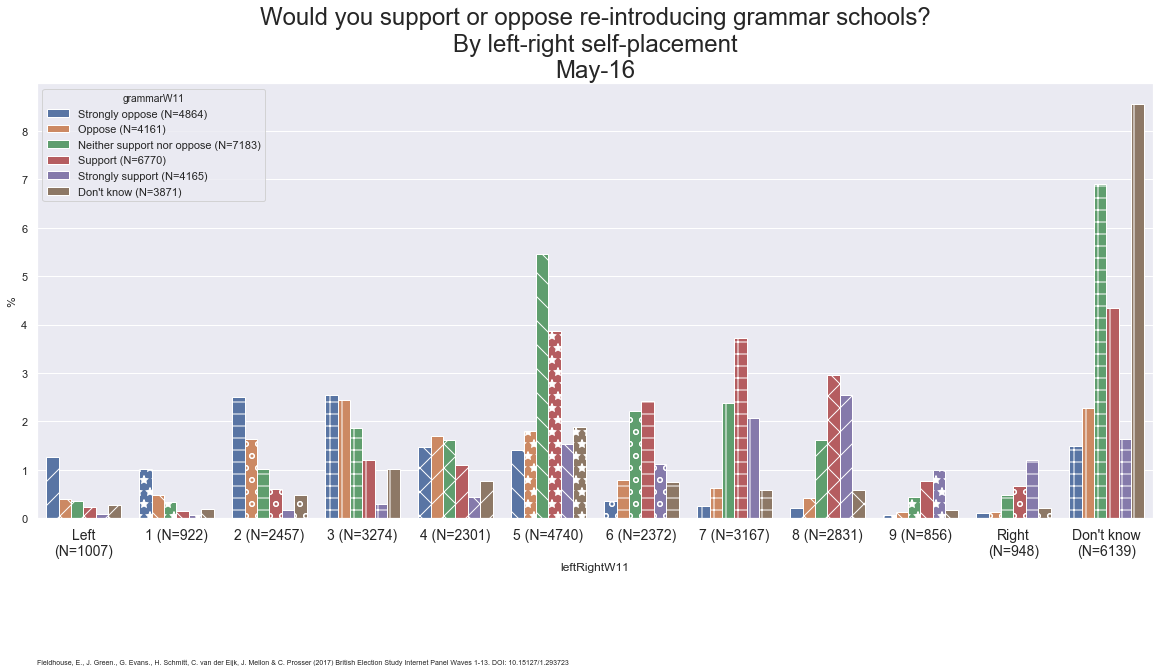

In [22]:
# VotedLabour2017 = BES_reduced_with_na["profile_past_vote_2017_Labour"]==1.0

wave = 8

var1 ="grammarW11"
var2 ="leftRightW11"


# df2 = govtHandouts
df2 = BES_Panel[var2]
#BES_Panel[var2]
df2 = df2.cat.rename_categories([str(x) for x in df2.cat.categories]) # force categories to be strings!
# df2.cat.rename_categories([str(x) for x in pan_dataset_ages[age_var].cat.categories],inplace=True)
df2.name = var2
df1 = BES_Panel[var1]
df1 = df1.cat.rename_categories([str(x) for x in df1.cat.categories])
# BES_Panel[var1]
# df1 = amalgamate_waves(BES_Panel,"immigSelf")#BES_Panel["immigSelfW14"]
# df1 = df1.cat.remove_categories(["Don't know"])
#amalgamate_waves(BES_Panel,"immigSelf")
# df2 = ever_voted_BNP
# BES_Panel[var2]#amal_al_3cat
# df2 = df2.cat.rename_categories(list(cat_dictionary[var2]) + ["Prefer not to answer / Don't know"])


date = BES_file_manifest[BES_file_manifest["Only_or_Combined"]=="Only"].set_index("Wave No").loc[wave,"Date_Start"]

nice_bar_plot(df1, df2, min_sample_size=1, normalize='all',drop_insig=False,
              text_width = 10,
              title_fontsize=24,
              char_limit=120,
              title="Would you support or oppose re-introducing grammar schools?"+"\n"+"By left-right self-placement"+"\n"+date)
#               mask = VotedLabour2017)




# # Define some hatches
# hatches = ['-', '+', 'x', '\\', '*', 'o']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])

In [23]:
# Treatment = "xgboost_dealVnodeal"
# var_stub = "dealVnodeal"

# var_list = ["dealVnodeal_Leave without a deal"]
# var_stub_list = [var_stub,"euRefVote_Leave the EU","euID_The leave side","dealVremain_Remain in the EU",
#                  "delayOrNoDeal_Delay Brexit until parliament can agree a deal","euRefDoOver_Yes","cancelBrexit__Strongly agree",
#                  "euRefpastVote_Leave the EU","pastvote_EURef_Leave the EU",
#                  "willOfPeople__Strongly agree","dealVnodeal_Leave without a deal","profile_eurefvote_Leave the EU",
#                  "regretsIHaveAFewEU__I did not vote", 'noDealShortTerm__Extremely good', 'noDealLongTerm__Extremely good',
#                  "remainVnodeal_Remain in the EU"]

Treatment = "xgboost_grammar"
var_stub = "grammar"
var_list = ["grammarW10W11__Strongly support"]
var_stub_list = [var_stub]


# ImmigDiff = get_diff(["likeCorbyn"])#.notnull().sum()

# var_list = ImmigDiff.columns

# ["profile_education_age","workingStatus","profile_work_stat",]

optional_mask = False
sample_wts = False
drop_other_waves = False


# Leavers only
def optional_mask_fn(wave=[]):
    return 1
#     return (BES_Panel["country"]=="England")
#     return (BES_Panel["profile_eurefvote"]=='Stay/remain in the EU')
#     return (BES_Panel["profile_past_vote_2017"]=="Labour")



def create_train(drop_other_waves):
    keep_list = BES_reduced_with_na.columns
    
    if drop_other_waves:
        # drop variables from other waves
        other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
        keep_list = [x for x in keep_list if not re.search( other_waves, x )]
        
    # drop key variables
    keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    
    return BES_reduced_with_na[keep_list]


def create_target(target_var):
    
    return BES_reduced_with_na[target_var]

objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1

alg = XGBRegressor(
 learning_rate =0.05,
 n_estimators= 1800,
 max_depth=10,
 min_child_weight=6,
 gamma=0,
 subsample=0.6,
 colsample_bytree=0.7,
 colsample_bylevel=.85,
 objective= objective,
 scale_pos_weight=1.0,
 reg_alpha=0.01,
 reg_lambda=1,
 njobs=3,
 seed=seed**2)



[0]	validation_0-rmse:1.95363
Will train until validation_0-rmse hasn't improved in 180.0 rounds.
[1]	validation_0-rmse:1.8838
[2]	validation_0-rmse:1.81815
[3]	validation_0-rmse:1.75715
[4]	validation_0-rmse:1.6995
[5]	validation_0-rmse:1.64543
[6]	validation_0-rmse:1.59521
[7]	validation_0-rmse:1.54841
[8]	validation_0-rmse:1.50381
[9]	validation_0-rmse:1.46324
[10]	validation_0-rmse:1.42488
[11]	validation_0-rmse:1.39017
[12]	validation_0-rmse:1.35685
[13]	validation_0-rmse:1.32609
[14]	validation_0-rmse:1.29764
[15]	validation_0-rmse:1.27135
[16]	validation_0-rmse:1.24734
[17]	validation_0-rmse:1.22471
[18]	validation_0-rmse:1.20386
[19]	validation_0-rmse:1.18451
[20]	validation_0-rmse:1.16677
[21]	validation_0-rmse:1.15077
[22]	validation_0-rmse:1.13588
[23]	validation_0-rmse:1.12237
[24]	validation_0-rmse:1.10933
[25]	validation_0-rmse:1.09762
[26]	validation_0-rmse:1.0875
[27]	validation_0-rmse:1.07795
[28]	validation_0-rmse:1.06942
[29]	validation_0-rmse:1.06125
[30]	validation

[252]	validation_0-rmse:0.967251
[253]	validation_0-rmse:0.967254
[254]	validation_0-rmse:0.967303
[255]	validation_0-rmse:0.967304
[256]	validation_0-rmse:0.967269
[257]	validation_0-rmse:0.967325
[258]	validation_0-rmse:0.967296
[259]	validation_0-rmse:0.967325
[260]	validation_0-rmse:0.96737
[261]	validation_0-rmse:0.967438
[262]	validation_0-rmse:0.967442
[263]	validation_0-rmse:0.967466
[264]	validation_0-rmse:0.96751
[265]	validation_0-rmse:0.967537
[266]	validation_0-rmse:0.967578
[267]	validation_0-rmse:0.967535
[268]	validation_0-rmse:0.967436
[269]	validation_0-rmse:0.967518
[270]	validation_0-rmse:0.96761
[271]	validation_0-rmse:0.967644
[272]	validation_0-rmse:0.967631
[273]	validation_0-rmse:0.967593
[274]	validation_0-rmse:0.967616
[275]	validation_0-rmse:0.967602
[276]	validation_0-rmse:0.967632
[277]	validation_0-rmse:0.967568
[278]	validation_0-rmse:0.967502
[279]	validation_0-rmse:0.967461
[280]	validation_0-rmse:0.967406
[281]	validation_0-rmse:0.967393
[282]	validat

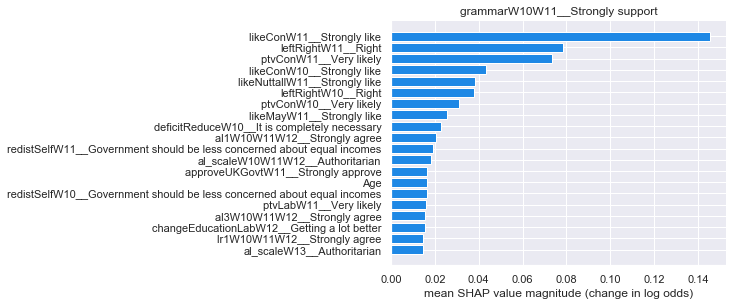

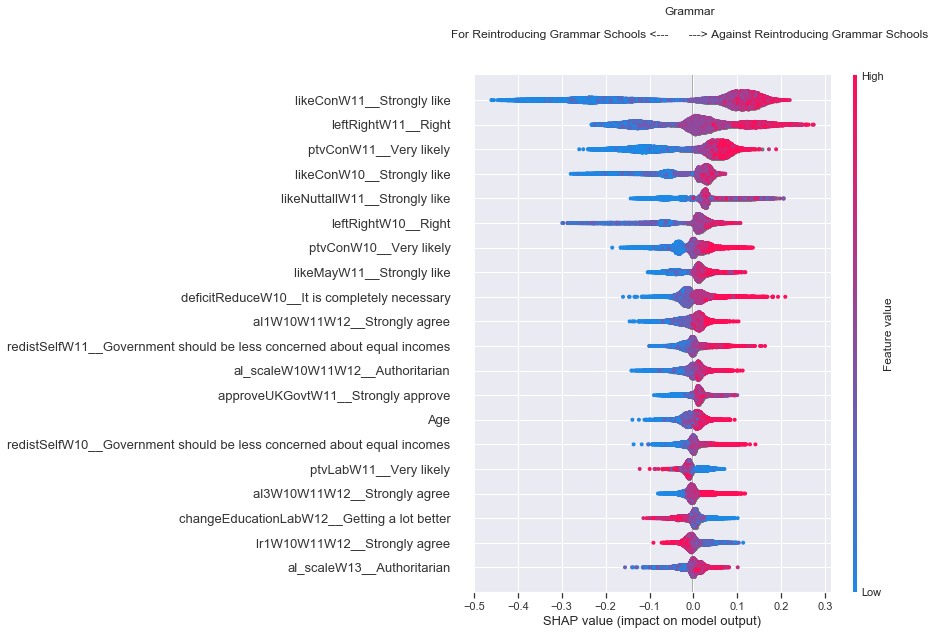

Wall time: 1h 57min 35s


In [25]:
%%time
colname = "Grammar"
# BES_cens = BES_cens_base[fertility_columns+age_columns+["leaveHanretty"]+["c11Degree"]]
xgboost_run(subdir=colname,min_features = min(BES_reduced_with_na.shape[1]-1,20),
           title = colname+"\n\nFor Reintroducing Grammar Schools <---      ---> Against Reintroducing Grammar Schools")